In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from IPython.display import Markdown, display

markdown_cells = [
"""# YouTube Recommendation Dataset — Notebook Summary

- Rows: 537, Columns: 21
- Key numeric columns: view_count, like_count, comment_count, engagement_rate, duration_seconds, video_age_days
- Key categorical columns: channel_title, category_id, definition, caption, video_length_category
""",
"""## Data Loading & Basic Checks

- CSV loaded into `df_yt`
- Inspected shape, head, info
- Checked for nulls and duplicates
- Verified no negative values for view/like/comment counts
""",
"""## Data Cleaning & Type Conversions

- Converted `Title`, `channel_title` to string
- Parsed `published_at` to datetime (UTC)
- Converted `duration` to timedelta and created `duration_seconds`
- Ensured correct dtypes via `df_yt.info()`
""",
"""## Feature Engineering

- `duration_seconds` (total seconds)
- `video_length_category`: Short (<=60s), Medium (<=600s), Long (>600s)
- `video_age_days` already present
- `interaction_per_day` = view_count / max(video_age_days, 1)
- `upload_hour`, `upload_day` extracted from `published_at`
- `is_trending` flagged using 75th percentile threshold on `view_count`
""",
"""## Exploratory Data Analysis (plots created)

- Histograms (log-scaled) of `view_count`, `like_count` (with hue by `definition`)
- KDE plots for `engagement_rate` (by `definition` and `caption`)
- Histograms / KDE for `duration_seconds`, `video_age_days`
- Distribution of `category_id` and top channels (`channel_title`.value_counts())
""",
"""## Quick Findings & Next Steps

- Inspect top channels and trending threshold (`threshold` variable)
- Analyze correlations between engagement_rate, likes_to_views_ratio, and view_count
- Group by `video_length_category`, `category_id`, `upload_hour` for aggregated insights
- Consider outlier handling, time-series trends, and simple predictive modeling (e.g., predicting views or trending)
"""
]

for cell in markdown_cells:
    display(Markdown(cell))

In [3]:
df_yt = pd.read_csv("youtube_recommendation_dataset -.csv")
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,PT1M51S,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,PT1M,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,PT18M2S,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,PT3M23S,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,PT3M35S,hd,True,0.077768,0.069856,0.007912,215,0


In [4]:
df_yt.shape

(537, 16)

In [5]:
df_yt.isnull().sum()

Title                      0
channel_title              0
published_at               0
category_id                0
view_count                 0
like_count                 0
comment_count              0
favorite_count             0
duration                   0
definition                 0
caption                    0
engagement_rate            0
likes_to_views_ratio       0
comments_to_views_ratio    0
duration_seconds           0
video_age_days             0
dtype: int64

In [6]:
df_yt.duplicated().sum()

np.int64(0)

In [7]:
df_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    537 non-null    object 
 1   channel_title            537 non-null    object 
 2   published_at             537 non-null    object 
 3   category_id              537 non-null    int64  
 4   view_count               537 non-null    int64  
 5   like_count               537 non-null    int64  
 6   comment_count            537 non-null    int64  
 7   favorite_count           537 non-null    int64  
 8   duration                 537 non-null    object 
 9   definition               537 non-null    object 
 10  caption                  537 non-null    bool   
 11  engagement_rate          537 non-null    float64
 12  likes_to_views_ratio     537 non-null    float64
 13  comments_to_views_ratio  537 non-null    float64
 14  duration_seconds         5

In [8]:
df_yt['Title'] = df_yt['Title'].astype('string')
df_yt['channel_title'] = df_yt['channel_title'].astype('string')
df_yt['published_at'] = pd.to_datetime(df_yt['published_at'])
df_yt['duration'] = pd.to_timedelta(df_yt['duration'])
df_yt['duration_seconds'] = pd.to_timedelta(df_yt['duration']).dt.total_seconds()

In [9]:
df_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Title                    537 non-null    string             
 1   channel_title            537 non-null    string             
 2   published_at             537 non-null    datetime64[ns, UTC]
 3   category_id              537 non-null    int64              
 4   view_count               537 non-null    int64              
 5   like_count               537 non-null    int64              
 6   comment_count            537 non-null    int64              
 7   favorite_count           537 non-null    int64              
 8   duration                 537 non-null    timedelta64[ns]    
 9   definition               537 non-null    object             
 10  caption                  537 non-null    bool               
 11  engagement_rate          537 non

In [10]:
df_yt[(df_yt['like_count'] < 0) | (df_yt['comment_count'] < 0) | (df_yt['view_count'] < 0)]

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days


In [11]:
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,False,0.106375,0.099928,0.006448,111.0,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60.0,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,False,0.015129,0.013593,0.001535,1082.0,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203.0,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215.0,0


In [12]:
threshold = df_yt['view_count'].quantile(0.75)
df_yt['is_trending'] = df_yt['view_count'] > threshold

In [13]:
df_yt['upload_hour'] = df_yt['published_at'].dt.hour
df_yt['upload_day'] = df_yt['published_at'].dt.day_name()

In [14]:
df_yt['interaction_per_day'] = df_yt['view_count'] / df_yt['video_age_days'].replace(0, 1)

In [15]:
def length_category(sec):
    if sec <= 60:
        return 'Short'
    elif sec <= 600:
        return 'Medium'
    else:
        return 'Long'

df_yt['video_length_category'] = df_yt['duration_seconds'].apply(length_category)

In [16]:
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,...,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days,is_trending,upload_hour,upload_day,interaction_per_day,video_length_category
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,...,0.106375,0.099928,0.006448,111.0,1,False,15,Sunday,1405647.0,Medium
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,...,0.012059,0.009652,0.002407,60.0,0,False,17,Monday,2776847.0,Short
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,...,0.015129,0.013593,0.001535,1082.0,0,False,22,Monday,1189857.0,Long
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,...,0.002419,0.000000,0.002419,203.0,1,False,9,Monday,5319161.0,Medium
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,...,0.077768,0.069856,0.007912,215.0,0,False,17,Monday,597542.0,Medium


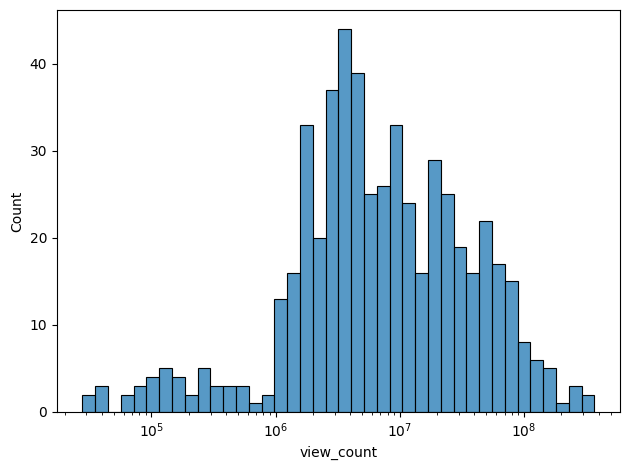

In [17]:
sns.histplot(df_yt,x='view_count',log_scale=True ,bins=40)
plt.tight_layout()
plt.show()

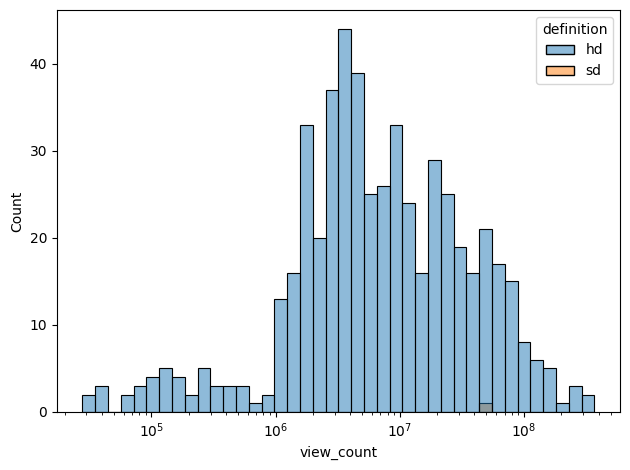

In [30]:
sns.histplot(df_yt,x='view_count',log_scale=True ,bins=40, hue='definition')
plt.tight_layout()
plt.show()

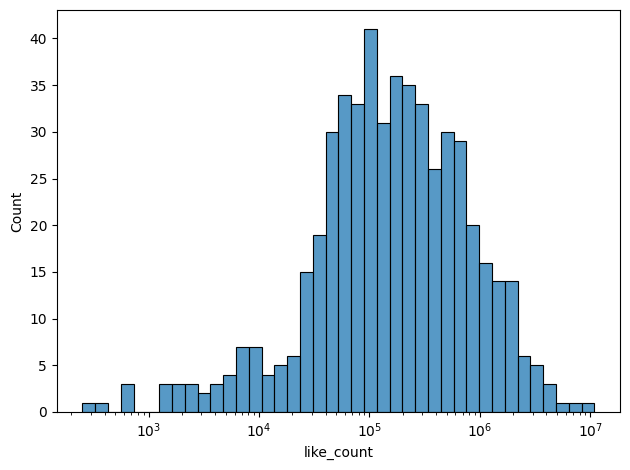

In [18]:
sns.histplot(df_yt,x='like_count',log_scale=True ,bins=40)
plt.tight_layout()
plt.show()

<Axes: xlabel='like_count', ylabel='Count'>

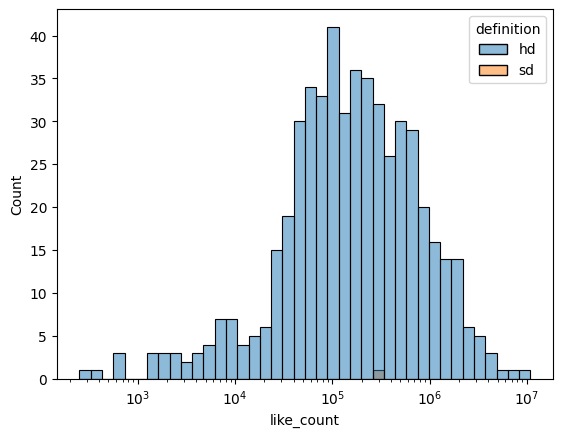

In [31]:
sns.histplot(df_yt,x='like_count',log_scale=True ,bins=40, hue='definition')

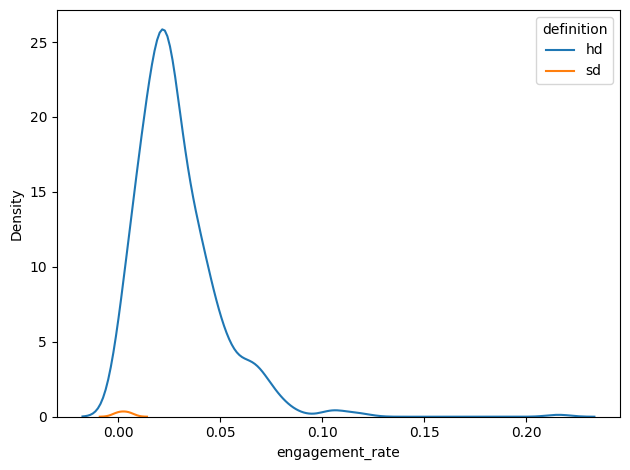

In [32]:
sns.kdeplot(df_yt,x='engagement_rate',hue='definition')
plt.tight_layout()
plt.show()

<Axes: xlabel='engagement_rate', ylabel='Density'>

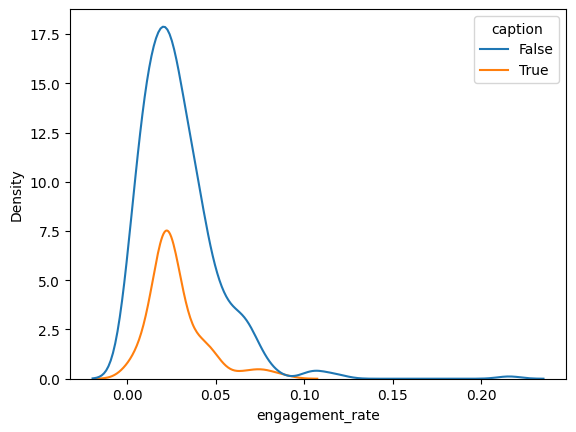

In [33]:
sns.kdeplot(df_yt,x='engagement_rate',hue='caption')

<Axes: xlabel='duration_seconds', ylabel='Count'>

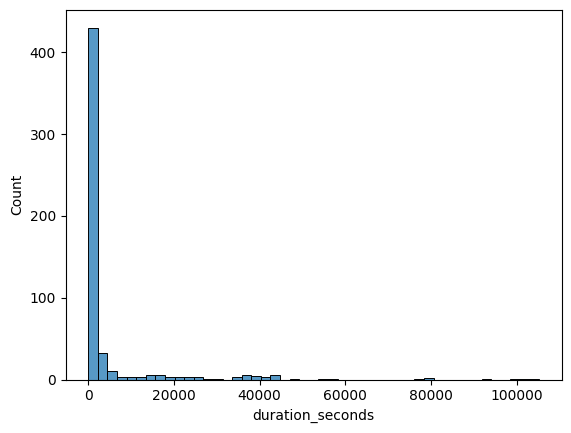

In [20]:
sns.histplot(df_yt,x='duration_seconds')

<Axes: xlabel='video_age_days', ylabel='Density'>

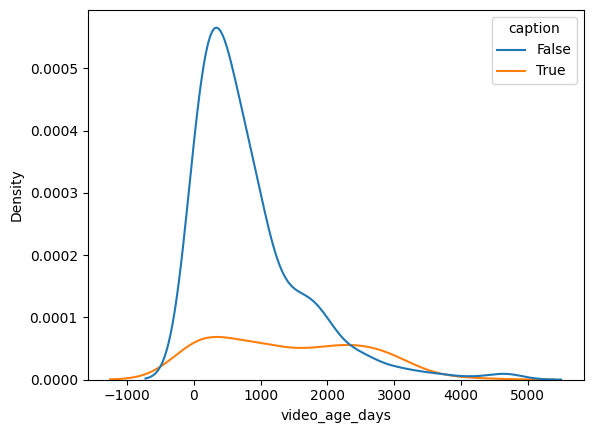

In [34]:
sns.kdeplot(df_yt,x='video_age_days',hue='caption')

<Axes: xlabel='category_id', ylabel='Count'>

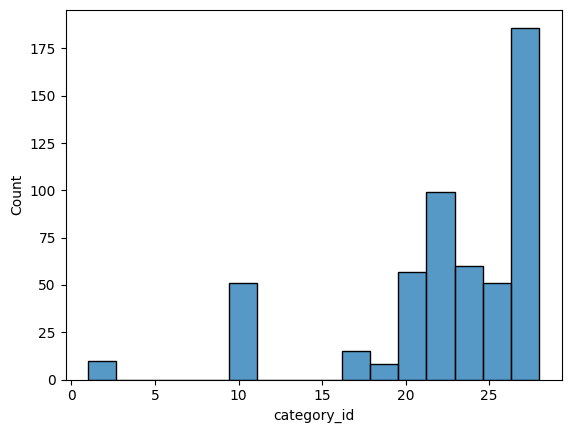

In [22]:
sns.histplot(df_yt,x='category_id')

In [26]:
df_yt['channel_title'].value_counts()[:10]

channel_title
freeCodeCamp.org           22
Apna College               18
CodeWithHarry              12
AOA Review                  9
Secret of yum               7
therainbowgirl              7
Village Cooking Channel     7
Programming with Mosh       7
3Blue1Brown                 6
wittySpace                  5
Name: count, dtype: Int64